In [1]:
import os, random, time, pickle, math
from collections import Counter
import numpy as np
from tqdm import trange

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

ALPHABET = [chr(ord("a") + i) for i in range(26)]
A2I = {c: i for i, c in enumerate(ALPHABET)}
I2A = {i: c for c, i in A2I.items()}

CORPUS_PATH = "corpus.txt"
TEST_PATH   = "test.txt"

print("Datasets loaded.")
if not os.path.exists(CORPUS_PATH):
    raise FileNotFoundError("corpus.txt not found in current directory.")
if not os.path.exists(TEST_PATH):
    raise FileNotFoundError("test.txt not found in current directory.")


Datasets loaded.


In [2]:
def load_corpus_clean(path):
    """Load and clean corpus.txt: lowercase, alphabetic-only, length filter."""
    words = []
    with open(path, "r", encoding="utf-8") as f:
        for ln in f:
            w = ln.strip().lower()
            if not w: 
                continue
            # keep only alphabetic words for corpus training (mandate requires corpus as source of truth)
            if w.isalpha():
                words.append(w)
    return words

def load_test_raw(path):
    """Load test.txt raw: keep lines as-is (no alphabetic filtering)."""
    lines = []
    with open(path, "r", encoding="utf-8") as f:
        for ln in f:
            w = ln.rstrip("\n").replace("\r","")
            if w == "": 
                continue
            lines.append(w)   # keep raw, no isalpha filter
    return lines

print("Loading and preprocessing corpus (clean) — training HMM will use this only.")
train_words = load_corpus_clean(CORPUS_PATH)
print(f"Corpus: {len(train_words)} words (cleaned).")

print("Loading test lines (raw) — NO preprocessing is applied to these lines (as requested).")
test_lines_raw = load_test_raw(TEST_PATH)
print(f"Test file lines: {len(test_lines_raw)} (raw).")

# quick corpus stats
if train_words:
    lens = [len(w) for w in train_words]
    print(f"Corpus lengths: min={min(lens)}, max={max(lens)}, mean={np.mean(lens):.2f}")
    freq = Counter("".join(train_words))
    print("Top 8 letters in corpus:", freq.most_common(8))
print("="*70)
# show hackathon mandate summary (from PDF)
print("Hackathon mandate summary (HMM + RL): training HMM on corpus.txt, agent uses HMM posterior to act. See problem statement for scoring formula. :contentReference[oaicite:1]{index=1}")
print("="*70)


Loading and preprocessing corpus (clean) — training HMM will use this only.
Corpus: 49979 words (cleaned).
Loading test lines (raw) — NO preprocessing is applied to these lines (as requested).
Test file lines: 2000 (raw).
Corpus lengths: min=1, max=24, mean=9.50
Top 8 letters in corpus: [('e', 49203), ('a', 42089), ('i', 42047), ('o', 35808), ('r', 33577), ('n', 33314), ('t', 32191), ('s', 29044)]
Hackathon mandate summary (HMM + RL): training HMM on corpus.txt, agent uses HMM posterior to act. See problem statement for scoring formula. :contentReference[oaicite:1]{index=1}


In [3]:
class BigramHMM:
    def __init__(self, alpha=0.5):
        self.alpha = float(alpha)
        self.V = 26
        self.trans = np.ones((self.V, self.V)) / self.V
        self.pi = np.ones(self.V) / self.V

    def fit(self, words):
        print("Fitting Bigram HMM (counts + Laplace smoothing) on corpus...")
        C = np.zeros((self.V, self.V), dtype=float)
        starts = np.zeros(self.V, dtype=float)
        for w in words:
            if len(w) == 0: 
                continue
            starts[A2I[w[0]]] += 1
            for a, b in zip(w[:-1], w[1:]):
                C[A2I[a], A2I[b]] += 1
        self.trans = (C + self.alpha) / (C.sum(axis=1, keepdims=True) + self.alpha * self.V + 1e-12)
        self.pi = (starts + self.alpha) / (starts.sum() + self.alpha * self.V + 1e-12)
        print("HMM fit complete. Example pi (first 8):", [f"{I2A[i]}:{self.pi[i]:.3f}" for i in range(8)])
        print("Sample transitions from 't':", [f"{I2A[j]}:{self.trans[A2I['t'], j]:.3f}" for j in range(8)])

    @staticmethod
    def _log(x):
        return np.log(x + 1e-300)

    @staticmethod
    def _logsumexp(a, axis=None):
        a_max = np.max(a, axis=axis, keepdims=True)
        s = np.sum(np.exp(a - a_max), axis=axis, keepdims=True)
        out = a_max + np.log(s + 1e-300)
        if axis is not None:
            out = np.squeeze(out, axis=axis)
        return out

    def forward_backward_letter_posterior(self, pattern, guessed_set):
        """
        pattern: string like '__a_e' or 'h_ll_'
        guessed_set: set of letters already guessed (chars)
        returns: a length-26 posterior over letters normalized for unguessed letters.
        """
        L = len(pattern)
        V = self.V
        if L == 0:
            out = np.ones(V)
            for g in guessed_set:
                if g in A2I: out[A2I[g]] = 0.0
            s = out.sum()
            return (out / s) if s > 0 else np.ones(V) / V

        # Build emission allowable indicator matrix E[t, c]
        E = np.zeros((L, V), dtype=float)
        revealed = set(ch for ch in pattern if ch != "_")
        wrong_guessed = set(ch for ch in guessed_set if ch not in revealed)
        for t, ch in enumerate(pattern):
            if ch == "_":
                for c in ALPHABET:
                    if c in wrong_guessed: 
                        continue
                    E[t, A2I[c]] = 1.0
            else:
                if ch in A2I:
                    E[t, A2I[ch]] = 1.0
        # safety: if a row is all zero, allow everything except wrong_guessed
        for t in range(L):
            if E[t].sum() == 0:
                for c in ALPHABET:
                    if c not in wrong_guessed:
                        E[t, A2I[c]] = 1.0

        logA = self._log(self.trans)
        logpi = self._log(self.pi)
        logB = np.log(E + 1e-300)  # 0 -> -inf; 1 -> 0

        # forward pass (log-alpha)
        log_alpha = np.full((L, V), -1e300)
        log_alpha[0] = logpi + logB[0]
        for t in range(1, L):
            temp = log_alpha[t-1][:, None] + logA   # shape (V, V)
            log_alpha[t] = self._logsumexp(temp, axis=0) + logB[t]

        # backward pass (log-beta)
        log_beta = np.full((L, V), -1e300)
        log_beta[-1] = 0.0
        for t in range(L-2, -1, -1):
            temp = logA + (logB[t+1] + log_beta[t+1])[None, :]
            log_beta[t] = self._logsumexp(temp, axis=1)

        # gamma (posterior per position)
        log_gamma = log_alpha + log_beta
        for t in range(L):
            log_gamma[t] -= self._logsumexp(log_gamma[t], axis=0)
        gamma = np.exp(log_gamma)  # normalized per position

        # aggregate posterior mass across blank positions
        post = np.zeros(V, dtype=float)
        for t, ch in enumerate(pattern):
            if ch == "_":
                post += gamma[t]
        # zero out already guessed letters
        for g in guessed_set:
            if g in A2I:
                post[A2I[g]] = 0.0
        s = post.sum()
        if s <= 0:
            # fallback to uniform over unseen letters
            post = np.zeros(V, dtype=float)
            unseen = [A2I[c] for c in ALPHABET if c not in guessed_set]
            if not unseen:
                post[:] = 1.0 / V
            else:
                for i in unseen: post[i] = 1.0
            s = post.sum()
        return post / s


In [4]:
class HangmanEnv:
    def __init__(self, words_list, hmm_model, max_lives=6):
        assert isinstance(words_list, (list, tuple)) and len(words_list) >= 1
        self.words = words_list
        self.hmm = hmm_model
        self.max_lives = max_lives
        self.reset()

    def reset(self):
        self.raw_word = random.choice(self.words)
        self.word = self.raw_word.lower()
        self.pattern = []
        for ch in self.word:
            if ch.isalpha():
                self.pattern.append("_")
            else:
                self.pattern.append(ch)
        self.guessed = set()
        self.lives = self.max_lives
        self.done = False
        self.repeated = 0
        return self.get_state()

    def get_state(self):
        patt_str = "".join(self.pattern)
        guessed_copy = set(self.guessed)
        posterior = self.hmm.forward_backward_letter_posterior(patt_str, guessed_copy)
        return {"pattern": patt_str, "guessed": guessed_copy, "lives": self.lives, "hmm": posterior}

    def step(self, letter):
        # returns state, reward, done
        if self.done:
            return self.get_state(), 0.0, True
        if letter in self.guessed:
            self.repeated += 1
            return self.get_state(), -2.0, False
        self.guessed.add(letter)
        # apply guess only to alpha positions
        revealed = 0
        for i, ch in enumerate(self.word):
            if ch.isalpha() and ch == letter and self.pattern[i] == "_":
                self.pattern[i] = letter
                revealed += 1
        if revealed > 0:
            reward = 2.0 + 1.0 * revealed  # base + per reveal
        else:
            self.lives -= 1
            reward = -5.0

        alpha_blanks = any(self.pattern[i] == "_" and self.word[i].isalpha() for i in range(len(self.word)))
        if not alpha_blanks:
            self.done = True
            reward += 50.0
        elif self.lives <= 0:
            self.done = True
            reward -= 10.0
        return self.get_state(), reward, self.done


In [5]:
class QAgent:
    def __init__(self):
        self.alpha = 0.3
        self.gamma = 0.95
        self.epsilon = 0.6
        self.eps_min = 0.05
        self.eps_decay = 0.9995
        self.q = {}

    @staticmethod
    def guessed_mask(guessed):
        return ''.join('1' if c in guessed else '0' for c in ALPHABET)

    @staticmethod
    def discretize_hmm(hmm_vec):

        return tuple(np.round(hmm_vec, 3).tolist())

    def state_key(self, state):
        patt = state["pattern"]
        gm = self.guessed_mask(state["guessed"])
        lives = int(state["lives"])
        hmmk = self.discretize_hmm(state["hmm"])
        return (patt, gm, lives, hmmk)

    def get_q(self, sk, action):
        return self.q.get((sk, action), 0.0)

    def choose_action(self, state):

        if random.random() < self.epsilon:
            choices = [c for c in ALPHABET if c not in state["guessed"]]
            return random.choice(choices) if choices else random.choice(ALPHABET)
        sk = self.state_key(state)
        hmm_prior = state["hmm"]
        best = None
        best_score = -1e9
        for c in ALPHABET:
            if c in state["guessed"]:
                continue
            qv = self.get_q(sk, c)
            score = qv + 1.5 * float(hmm_prior[A2I[c]])  # HMM bias weight
            if score > best_score:
                best_score = score
                best = c
        return best if best is not None else random.choice(ALPHABET)

    def update(self, state, action, reward, next_state, done):
        sk = self.state_key(state)
        nk = self.state_key(next_state)
        cur = self.get_q(sk, action)
        if done:
            target = reward
        else:
            avail_next = [a for a in ALPHABET if a not in next_state["guessed"]]
            if not avail_next:
                max_next = 0.0
            else:
                max_next = max([self.get_q(nk, a) for a in avail_next])
            target = reward + self.gamma * max_next
        self.q[(sk, action)] = cur + self.alpha * (target - cur)

    def decay_epsilon(self):
        self.epsilon = max(self.eps_min, self.epsilon * self.eps_decay)


In [6]:
def train_agent_with_hmm(hmm_model, train_vocab, episodes=10000, print_every=200):
    env = HangmanEnv(train_vocab, hmm_model, max_lives=6)
    agent = QAgent()
    start_time = time.time()
    print(f"Training Q-agent for {episodes} episodes (HMM already trained).")
    for ep in range(1, episodes + 1):
        state = env.reset()
        total_reward = 0.0
        done = False
        steps = 0
        while not done and steps < (len(env.word) + 40):
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            agent.update(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            steps += 1
        agent.decay_epsilon()
        if (ep % print_every == 0) or ep == 1 or ep == episodes:
            elapsed = time.time() - start_time
            print(f"Episode {ep}/{episodes} | last_reward={total_reward:.2f} | eps={agent.epsilon:.4f} | elapsed={elapsed:.1f}s")
    print("Training finished. Total time: %.1fs" % (time.time() - start_time))
    return agent


In [7]:
def evaluate_agent_on_raw_test(agent, hmm_model, test_lines, n_games=2000):
    # We will play n_games games using the raw lines. For any line, the env will treat non-alpha chars as revealed.
    backup_eps = agent.epsilon
    agent.epsilon = 0.0  # greedy evaluation

    # prepare exactly n_games items: sample without altering lines (we may repeat if fewer lines)
    eval_list = []
    if len(test_lines) >= n_games:
        # sample without replacement for variety
        eval_list = random.sample(test_lines, n_games)
    else:
        # if fewer than required, repeat randomly until length reached
        eval_list = test_lines.copy()
        while len(eval_list) < n_games:
            eval_list.append(random.choice(test_lines))

    wins = 0
    total_wrong = 0
    total_repeated = 0
    for w in eval_list:
        env = HangmanEnv([w], hmm_model, max_lives=6)
        state = env.reset()
        done = False
        # safety cap: allow up to len(word)+50 steps
        step_cap = max(100, len(env.word) + 50)
        steps = 0
        while not done and steps < step_cap:
            a = agent.choose_action(state)
            prev_guessed = set(env.guessed)
            state, reward, done = env.step(a)
            # interpret reward codes for counts
            if reward == -5.0:
                total_wrong += 1
            if reward == -2.0:
                total_repeated += 1
            steps += 1
        # success if no alpha blanks left
        # env.get_state()["pattern"] contains non-alpha as revealed; check for any alpha blanks
        patt = state["pattern"]
        remaining_alpha_blanks = any((patt[i] == "_" and env.word[i].isalpha()) for i in range(len(patt)))
        if not remaining_alpha_blanks:
            wins += 1

    sr = wins / n_games
    final_score = (sr * n_games) - (5.0 * total_wrong) - (2.0 * total_repeated)
    agent.epsilon = backup_eps
    print("\nEvaluation Summary (test.txt used RAW, no preprocessing):")
    print(f"Games: {n_games}, Wins: {wins}, Success rate: {sr*100:.2f}%")
    print(f"Total wrong guesses: {total_wrong}, Total repeated guesses: {total_repeated}")
    print(f"Final Score: {final_score:.1f}")
    return {"games": n_games, "wins": wins, "sr": sr, "wrong": total_wrong, "repeat": total_repeated, "score": final_score}


=== Enhanced Pipeline (auto-plots at end) ===
Fitting Bigram HMM (counts + Laplace smoothing) on corpus...
HMM fit complete. Example pi (first 8): ['a:0.072', 'b:0.047', 'c:0.083', 'd:0.046', 'e:0.037', 'f:0.029', 'g:0.030', 'h:0.039']
Sample transitions from 't': ['a:0.105', 'b:0.002', 'c:0.008', 'd:0.001', 'e:0.212', 'f:0.004', 'g:0.001', 'h:0.087']
Training agent for 10000 episodes...


  5%|▌         | 523/10000 [00:03<01:01, 153.62it/s]

Ep   500 | reward= -36.00 | eps=0.467


 10%|█         | 1027/10000 [00:06<00:57, 156.82it/s]

Ep  1000 | reward= -30.00 | eps=0.364


 15%|█▌        | 1518/10000 [00:10<00:53, 157.50it/s]

Ep  1500 | reward= -33.00 | eps=0.283


 20%|██        | 2023/10000 [00:13<01:04, 124.04it/s]

Ep  2000 | reward= -18.00 | eps=0.221


 25%|██▌       | 2505/10000 [00:26<03:28, 35.90it/s] 

Ep  2500 | reward= -27.00 | eps=0.172


 30%|███       | 3003/10000 [00:39<03:21, 34.69it/s]

Ep  3000 | reward=  71.00 | eps=0.134


 35%|███▌      | 3507/10000 [00:51<02:24, 45.05it/s]

Ep  3500 | reward= -21.00 | eps=0.104


 40%|████      | 4008/10000 [01:03<02:30, 39.92it/s]

Ep  4000 | reward= -37.00 | eps=0.081


 45%|████▌     | 4504/10000 [01:15<02:30, 36.64it/s]

Ep  4500 | reward= -28.00 | eps=0.063


 50%|█████     | 5006/10000 [01:27<01:46, 46.71it/s]

Ep  5000 | reward= -34.00 | eps=0.050


 55%|█████▌    | 5508/10000 [01:39<01:54, 39.10it/s]

Ep  5500 | reward= -31.00 | eps=0.050


 60%|██████    | 6004/10000 [01:54<01:28, 45.19it/s]

Ep  6000 | reward= -25.00 | eps=0.050


 65%|██████▌   | 6519/10000 [01:59<00:22, 155.20it/s]

Ep  6500 | reward= -30.00 | eps=0.050


 70%|███████   | 7017/10000 [02:03<00:23, 127.15it/s]

Ep  7000 | reward=  53.00 | eps=0.050


 75%|███████▌  | 7510/10000 [02:07<00:21, 117.69it/s]

Ep  7500 | reward= -26.00 | eps=0.050


 80%|████████  | 8012/10000 [02:11<00:13, 149.10it/s]

Ep  8000 | reward= -15.00 | eps=0.050


 85%|████████▌ | 8525/10000 [02:14<00:09, 148.16it/s]

Ep  8500 | reward=  86.00 | eps=0.050


 90%|█████████ | 9031/10000 [02:18<00:06, 160.75it/s]

Ep  9000 | reward= -18.00 | eps=0.050


 95%|█████████▌| 9521/10000 [02:21<00:02, 165.17it/s]

Ep  9500 | reward= -19.00 | eps=0.050


100%|██████████| 10000/10000 [02:25<00:00, 68.81it/s] 


Ep 10000 | reward=  77.00 | eps=0.050

Evaluation Summary (test.txt used RAW, no preprocessing):
Games: 2000, Wins: 675, Success rate: 33.75%
Total wrong guesses: 9002, Total repeated guesses: 0
Final Score: -44335.0

📊 Generating summary plots...


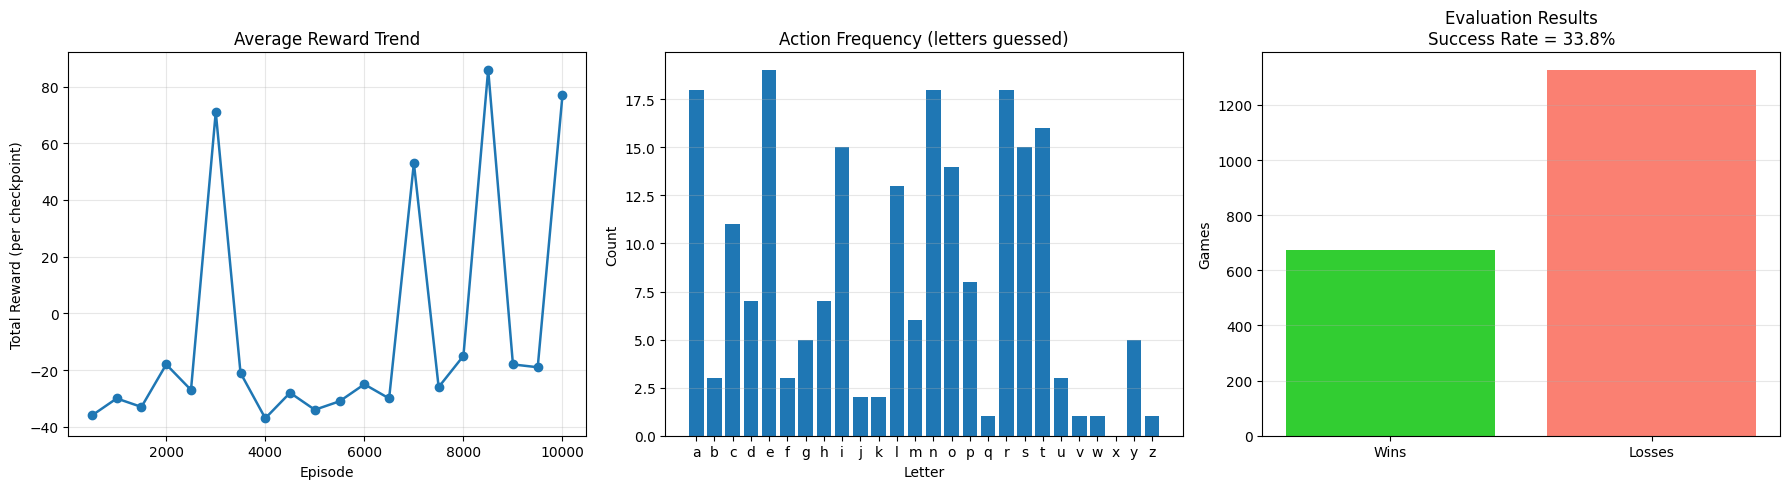

✅ Plots generated successfully.

=== Pipeline complete ===


In [8]:
import matplotlib.pyplot as plt
from collections import defaultdict

def visualize_summary(training_log, eval_result):
    """Auto-generate plots at the end of training/evaluation."""
    print("\n📊 Generating summary plots...")

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1️⃣ Reward trend
    if training_log:
        episodes = [ep for ep, r, _ in training_log]
        rewards = [r for _, r, _ in training_log]
        axes[0].plot(episodes, rewards, marker='o', linewidth=1.8)
        axes[0].set_title("Average Reward Trend")
        axes[0].set_xlabel("Episode")
        axes[0].set_ylabel("Total Reward (per checkpoint)")
        axes[0].grid(alpha=0.3)

    # 2️⃣ Action frequency
    freq = defaultdict(int)
    for _, _, acts in training_log:
        for a in acts:
            freq[a] += 1
    xs = list(ALPHABET)
    ys = [freq[c] for c in xs]
    axes[1].bar(xs, ys)
    axes[1].set_title("Action Frequency (letters guessed)")
    axes[1].set_xlabel("Letter")
    axes[1].set_ylabel("Count")
    axes[1].grid(axis='y', alpha=0.3)

    # 3️⃣ Win/Loss bar
    wins = eval_result["wins"]
    losses = eval_result["games"] - wins
    axes[2].bar(["Wins", "Losses"], [wins, losses],
                color=["limegreen", "salmon"])
    axes[2].set_title(f"Evaluation Results\nSuccess Rate = {eval_result['sr']*100:.1f}%")
    axes[2].set_ylabel("Games")
    axes[2].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()
    print("✅ Plots generated successfully.")


def main_pipeline_with_plots():
    print("=== Enhanced Pipeline (auto-plots at end) ===")

    # 1️ Train HMM
    hmm = BigramHMM(alpha=0.5)
    hmm.fit(train_words)

    # 2️ Train agent, collect logs every 500 episodes
    env = HangmanEnv(train_words, hmm)
    agent = QAgent()
    training_log = []
    episodes = 10000
    print(f"Training agent for {episodes} episodes...")
    for ep in trange(1, episodes+1):
        s = env.reset()
        total_reward = 0.0
        actions = []
        done = False
        while not done:
            a = agent.choose_action(s)
            s2, r, done = env.step(a)
            agent.update(s, a, r, s2, done)
            s = s2
            total_reward += r
            actions.append(a)
        agent.decay_epsilon()
        if ep % 500 == 0:
            training_log.append((ep, total_reward, actions))
            print(f"Ep {ep:5d} | reward={total_reward:7.2f} | eps={agent.epsilon:.3f}")

    # 3️ Evaluate on raw test lines
    results = evaluate_agent_on_raw_test(agent, hmm, test_lines_raw, n_games=2000)

    # 4️ Auto-plot summaries
    visualize_summary(training_log, results)

    # 5️ Save artifacts
    with open("trained_q_table.pkl", "wb") as f:
        pickle.dump(agent.q, f)
    with open("trained_hmm.pkl", "wb") as f:
        pickle.dump({"trans": hmm.trans, "pi": hmm.pi}, f)

    print("\n=== Pipeline complete ===")
    return agent, hmm, results


# Run this cell only once (will run everything and auto-plot at the end)
if __name__ == "__main__":
    agent, hmm, metrics = main_pipeline_with_plots()
